In [14]:
from pathlib import Path
import pandas as pd
import numpy as np
import gensim, spacy
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from wordcloud import WordCloud
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import plotly.express as px
import pyLDAvis
import pyLDAvis.gensim_models
import warnings
warnings.filterwarnings("ignore")

In [15]:
BASE_DIR = Path.cwd().parent
stop_words = stopwords.words('english')
PALETTE = px.colors.qualitative.Prism

In [16]:
df_hosts_reviews_en = pd.read_parquet(BASE_DIR / 'processed_data' / 'hosts_reviews_en_labeled.parquet')

In [17]:
df_hosts_reviews_en = df_hosts_reviews_en.query('sentiment_label_class == 0').reset_index()

In [18]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df_hosts_reviews_en['comments'].values.tolist()
data_words = list(sent_to_words(data))
print(data_words[0])

['stayed', 'three', 'nights', 'couldnt', 'helpful', 'soon', 'got', 'showed', 'us', 'get', 'around', 'visit', 'place', 'conveniently', 'located', 'metro', 'station', 'walking', 'distance', 'market', 'many', 'restaurants', 'clean', 'privacy', 'issue', 'despite', 'guests', 'staying', 'well', 'wifi', 'reliable', 'youre', 'vacation', 'doesnt', 'really', 'matter']


In [19]:
nlp = spacy.load("en_core_web_sm")
stop_words.append('also')
bigram = gensim.models.Phrases(data_words, min_count=1, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    #texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

# call the cached function
data_ready = process_words(data_words)

In [20]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=5,
                                           passes=5,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

lda_model.print_topics()

[(0,
  '0.023*"host" + 0.015*"room" + 0.013*"leave" + 0.010*"clean" + 0.010*"place" + 0.009*"bed" + 0.009*"get" + 0.009*"really" + 0.008*"bathroom" + 0.008*"go"'),
 (1,
  '0.054*"apartment" + 0.033*"stay" + 0.017*"location" + 0.017*"place" + 0.013*"need" + 0.010*"host" + 0.009*"photo" + 0.008*"price" + 0.007*"problem" + 0.006*"cosy"')]

In [21]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,3), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['dominant_topic', 'percent_contribution', 'topic_keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    contents.name = 'text'
    sent_topics_df = (df_hosts_reviews_en.merge(sent_topics_df, left_index=True, right_index=True)
                                    .merge(contents, left_index=True, right_index=True)
                                    .drop('index', axis=1))
    return(sent_topics_df)


df_dominant_topic = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)
df_dominant_topic

,level_0,date,listing_id_encod,listing_id,reviewer_id,reviewer_name,comments,host_id,host_name,host_description,...,review_scores_location,review_scores_value,comments_language,description_language,sentiment_label,sentiment_label_class,dominant_topic,percent_contribution,topic_keywords,text
0,74,2014-06-08,2.0,1.644480e+05,13461507.0,Sherry,stayed three nights couldnt helpful soon got s...,784312.0,Li,double room central stockholm wifi renting nic...,...,4.83,4.77,en,en,-0.1869,0,1,0.631,"apartment, stay, location, place, need, host, ...","[night, couldnt_helpful, soon, get, get_around..."
1,341,2016-10-29,103.0,2.106913e+06,97097053.0,Maxim,cozy flat,10741379.0,Moa,cosy quiet studio kungsholmen set district cen...,...,4.73,4.61,en,en,0.0000,0,1,0.507,"apartment, stay, location, place, need, host, ...","[cozy, flat]"
2,347,2018-07-28,103.0,2.106913e+06,196417596.0,Elena,smallclean apartment every time,10741379.0,Moa,cosy quiet studio kungsholmen set district cen...,...,4.73,4.61,en,en,0.0000,0,1,0.831,"apartment, stay, location, place, need, host, ...","[smallclean, apartment, every_time]"
3,488,2017-03-27,105.0,2.166026e+06,110430708.0,Jerome,nothing short amazing 1010 would book thank host,4455221.0,Janu,stockholm house close fairtown cool retro vill...,...,4.70,4.74,en,en,-0.1461,0,1,0.890,"apartment, stay, location, place, need, host, ...","[short, amazing, would_book, thank, host]"
4,522,2018-08-16,105.0,2.166026e+06,116636414.0,宇星,house really big location convenient get city ...,4455221.0,Janu,stockholm house close fairtown cool retro vill...,...,4.70,4.74,en,en,0.0000,0,1,0.711,"apartment, stay, location, place, need, host, ...","[really, big, location, convenient, get_city, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,69340,2023-03-30,2697.0,7.914385e+17,446637412.0,Liliana,apartment gut located host always available qu...,493068067.0,Nazar,mysig lägenhet bright beautiful spacious apart...,...,5.00,5.00,en,en,0.0000,0,1,0.928,"apartment, stay, location, place, need, host, ...","[apartment, gut, locate, host_alway, available..."
1231,69351,2023-02-17,2640.0,7.614526e+17,27141590.0,Martynas,cosy place close city,168568871.0,Casper Fredrik,private apartment house private stylish apartm...,...,4.86,4.71,en,en,0.0000,0,1,0.867,"apartment, stay, location, place, need, host, ...","[cosy, place, close_city]"
1232,69477,2023-02-24,2723.0,8.021823e+17,286560136.0,Valerie,difficult locate reach landlord particularly s...,465046893.0,Thomas,apartment stockholm city one room apartment 28...,...,3.00,1.00,en,en,-0.0534,0,1,0.820,"apartment, stay, location, place, need, host, ...","[difficult, locate, reach, particularly, safe,..."
1233,69540,2023-03-10,2777.0,8.308865e+17,7781365.0,Lotta,wanted cancel place bed space bedding two peop...,501923445.0,Sidar,super apartment good location enjoy stylish ex...,...,4.00,3.00,en,en,-0.6705,0,0,0.911,"host, room, leave, clean, place, bed, get, rea...","[want, cancel, place, bed, space, bed, two_peo..."


In [22]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.129901  0.0       1        1  65.051456
1     -0.129901  0.0       2        1  34.948544, topic_info=           Term        Freq       Total Category  logprob  loglift
22    apartment  374.000000  374.000000  Default  30.0000  30.0000
35         stay  262.000000  262.000000  Default  29.0000  29.0000
34     location  111.000000  111.000000  Default  28.0000  28.0000
144        need   84.000000   84.000000  Default  27.0000  27.0000
331        room  175.000000  175.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
496   different   24.830760   30.369532   Topic2  -5.5423   0.8499
239     problem   46.210699   92.872857   Topic2  -4.9211   0.3533
187      little   26.600881   36.573291   Topic2  -5.4734   0.7329
26         host   61.301862  328.550795   Topic2  -4.6386  -0.6276
1236    general   20.159312   23.516267   Topic2  -5.7507   0.8973

[120 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
680       1  0.045948  absolutely
680       2  0.918966  absolutely
135       1  0.081369   advertise
135       2  0.895055   advertise
267       1  0.990541      airbnb
...     ...       ...         ...
134       2  0.017627        wait
350       1  0.987425      window
350       2  0.023510      window
544       1  0.981966        work
544       2  0.017535        work

[161 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [23]:
topics = lda_model.show_topics(formatted=False)

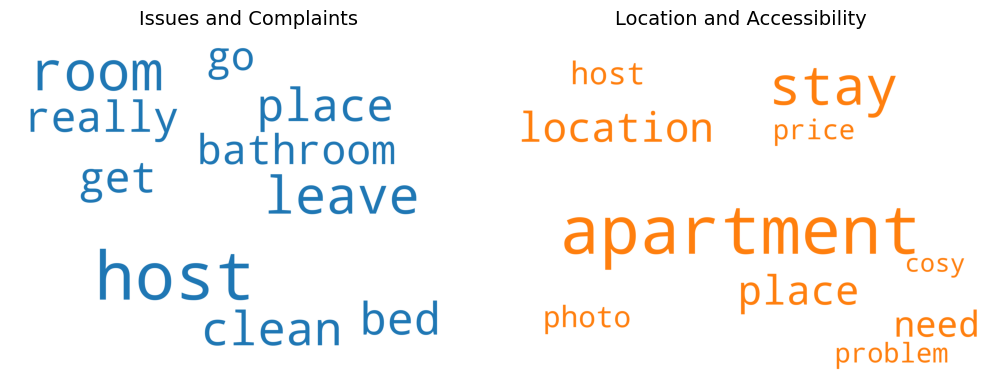

In [24]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

fig, axes = plt.subplots(1, 2, figsize=(10,10), sharex=True, sharey=True)

groups = {0: 'Issues and Complaints',
          1: 'Location and Accessibility',
          2: 'Host and Service Experience'
        }

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=350)
    plt.gca().imshow(cloud)
    plt.gca().set_title(groups.get(i), fontdict=dict(size=14))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=30, hspace=10)
plt.axis('off')
#plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [25]:
numnber_topic_by_neighbourhood = (df_dominant_topic.groupby(['neighbourhood', 'dominant_topic'])
        .agg(number_of_reviews=('number_of_reviews', 'count'))
        .sort_values('number_of_reviews', ascending=False)
        .reset_index())
numnber_topic_by_neighbourhood 

,neighbourhood,dominant_topic,number_of_reviews
0,Södermalms,0,313
1,Södermalms,1,287
2,Kungsholmens,0,85
3,Kungsholmens,1,83
4,Norrmalms,1,78
5,Norrmalms,0,71
6,Enskede-Årsta-Vantörs,1,38
7,Enskede-Årsta-Vantörs,0,31
8,Hägersten-Liljeholmens,1,24
9,Östermalms,1,23


In [26]:
# Define a custom color mapping function
def get_tile_color(tile_path):
    # Get the name of the neighbourhood and the dominant topic from the tile path
    neighbourhood, dominant_topic = tile_path[-2:]

    # Assign a specific color to each combination of neighbourhood and dominant topic
    if dominant_topic == 'topic 0' and neighbourhood == 'Neighbourhood 1':
        return 'red'
    elif dominant_topic == 'topic 1' and neighbourhood == 'Neighbourhood 2':
        return 'green'
    else:
        # Use the default color scale for all other tiles
        return None

# Create the treemap with the custom color mapping function
fig = px.treemap(
    numnber_topic_by_neighbourhood,
    path=['neighbourhood', 'dominant_topic'],
    values='number_of_reviews',
    color_discrete_sequence=PALETTE,
    color_continuous_midpoint=np.average(numnber_topic_by_neighbourhood['number_of_reviews']),
)

# Apply the custom color mapping function to each tile
fig.data[0].marker.colors = [get_tile_color(tile_path) for tile_path in fig.data[0].ids]

# Show the figure
fig.show()